### **Machine Learning em Visão Computacional**

   Neste notebook, nós iremos apresentar um modelo de machine learning para um problema de classificação multiclasse (_multiclass classification problem_).
    
   Nós usamos e nos guiamos pelo código escrito por A. Amantini e P. Markovics e disponibilizado no [NextJournal](https://run.nextjournalusercontent.com/gkoehler/pytorch-mnist# "MNIST Handwritten Digit Recognition in Pytorch").
    
   Escolhemos este código como referência, mas poderíamos ter escolhido qualquer outro dentre os demonstrativos de treinamento de um modelo de _**redes neurais convolucionais usando PyTorch**_, porque a maioria que encontramos estavam bem estruturados e explicados, portanto foi mera questão de simpatia.


***
---

__Importando as bibliotecas__

> Também precisamos importar a numpy para _debuggar_ uma parte do código, por algum motivo.

In [74]:
import torch
import torchvision

from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt

__Preparando o dataset__

Aqui estamos definindo os hiperparâmetros, que são fundamentais para o modelo.

> O número de épocas define quantas vezes o algoritmo passará (em _loop_) pelas amostras de treinamento.

> A taxa de aprendizagem determina quando a rede neural converge para os valores mínimos. Quando escolhemos uma taxa muito baixa, o aprendizado é lento, mas quando é muito baixa, pode aumentar a chance de perda. Ela pode ser dinâmica conforme o loop da época.

> O momentum é um algoritmo de otimização que substitui o gradiente atual com a média exponencial móvel dos gradientes até então.

> Por fim, a respeito do "random(_seed) é de bom tom usar um algoritmo para aleatorizar os dados, para que o experimento possa ser reproduzível.

In [75]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch_backend_cudnn_enabled = False
torch.manual_seed(random_seed)

> Acima nós inicializamos os DataLoaders em _batch_size_train_ e _test_ com os respectivos valores de treinamento e teste do modelo e abaixo definimos os valores padrão (no caso do MNIST) para a normalização.

In [76]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(r'/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307), (0.3081))
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(r'/files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307), (0.3081))
                               ])),
    batch_size=batch_size_test, shuffle=True)

>> Demonstração de como um _batch_ de dados de treino é descrito em uma matriz,

In [77]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 1, 28, 28])

#### que nos retorna a informação de que _batch_ é um tensor de tamanho
    [(1000, 1, 28, 28)]
#### e significa:
    1000 exemplos de imagens em escala de cinza de 28x28 pixels

***
__Amostra pré-treinamento__

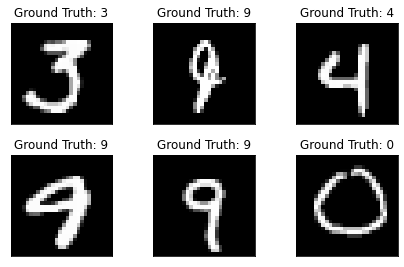

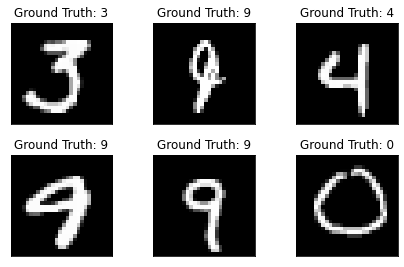

In [78]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],
               cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

fig

***

__Construindo da rede neural__

> Para construir nossa CNN, nós construímos uma classe própria. Nela, utilizamos camadas 2D seguidas de duas camadas lineares, que são ativadas por unidades lineares retificadas (ReLU) e também camadas de _dropout_ para regularização. 

In [79]:
import torch.nn.functional as F
from torch import nn, optim

In [80]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

> Então, inicializamos a rede e o otimizador:

In [81]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

__Treinando o modelo__

Aqui nós definimos a interação do _for loop_ em uma vez por epoch, em que batch é manipulado pelo DataLoader e é onde implementamos mecanismos muito importantes:

``` python
Optimizer.zero_grad()
```
> põe o valor dos gradientes em zero, pois o modo padrão acumula gradientes ao longo das epochs.

``` python
Backward()
```
> é uma chamada que coleta um novo conjunto de gradientes que são então propagados para atrás para os parâmetros da rede usando o
``` python
optimizer.step()
```

In [82]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Training epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network.state_dict(), './data/MNIST/raw/results/model.pth')
        torch.save(optimizer.state_dict(), './data/MNIST/raw/results/optimizer.pth')           

In [83]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

> Nós criamos listas para armazenarem os valores de perda nas rodadas de treino e teste:

In [84]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

***
__Amostra de teste sem treino prévio, para demonstrar o estado dos parâmetros inicializados aleatoriamente___

In [85]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\SOFIA2~1\AppData\Local\Temp/ipykernel_20332/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.2307, Accuracy: 88/10000 (1%)


Test set: Avg. loss: 0.2313, Accuracy: 182/10000 (2%)


Test set: Avg. loss: 0.2308, Accuracy: 282/10000 (3%)


Test set: Avg. loss: 0.2306, Accuracy: 381/10000 (4%)


Test set: Avg. loss: 0.2308, Accuracy: 472/10000 (5%)


Test set: Avg. loss: 0.2308, Accuracy: 567/10000 (6%)


Test set: Avg. loss: 0.2311, Accuracy: 651/10000 (7%)


Test set: Avg. loss: 0.2313, Accuracy: 744/10000 (7%)


Test set: Avg. loss: 0.2312, Accuracy: 836/10000 (8%)


Test set: Avg. loss: 0.2312, Accuracy: 924/10000 (9%)

Training epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Training epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Training epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Training epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Training epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Training epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Training epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Training epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Training epoch: 1 [5120/60000 (9%)]	L

***
__Treino e teste__

> Então, definimos como será o treinamento:

In [86]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './data/MNIST/raw/results/model.pth')
            torch.save(optimizer.state_dict(), './data/MNIST/raw/results/optimizer.pth')    

> E o teste:

In [87]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

> Finalmente, o treinamento qualificado:

In [88]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.196305


C:\Users\SOFIA2~1\AppData\Local\Temp/ipykernel_20332/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/60000 (1%)]	Loss: 0.184742
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.217813
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.277363
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.213091
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.191136
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.217760
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.357299
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.204942
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.333242
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.179404
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.158846
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.319827
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.124468
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.192223
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.290876
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.540425
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.251522
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.193120
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.356452
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.127659
Train Epoch: 1 [13440/60

OSError: [Errno 22] Invalid argument: './data/MNIST/raw/results/model.pth'

> Na última vez que testamos o código, a precisão chegou em 98%! E fica por aí mesmo. No código original eles publicaram 97%, que já é 10% melhor do que antes do treinamento.

__Para ilustrar, um gráfico:__

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.xlabel('training samples seen')
plt.ylabel('negative log likelihood loss')
fig

> E, para ilustrar melhor, o resultado do teste com os dígitos em si:

In [ ]:
with torch.no_grad():
    output = network(example_data)

__Amostra pós-treinamento__

In [ ]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Predição: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

***

__Treino a partir de checkpoints__

> Podemos retomar a inicialização, o treino e a otimização do modelo a partir de checkpoints no treinamento através dos state_dicts:

In [ ]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [ ]:
network_state_dict = torch.load(model.pth)
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load(optimizer.pth)
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for i in range(4,9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

> Para encerrar, demonstramos em gráfico que o treinamento volta a ocorrer de forma gradual e otimizada:

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig